# Aprendizado de Máquina em Séries Temporais

### Modelo SARIMA para predição de temperaturas de SST - Sea Surface Temperature Forecasting

### Introdução

Modelos SARIMA são modelos univariados para séries temporais. O acrônimo SARIMA significa modelos AutoRegressivos Integrados de Médias Móveis com Sazonalidade. [Referência](https://analisemacro.com.br/economia/comentario-de-conjuntura/modelos-sarima/)

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")

In [2]:
from netuno import SSTHelper

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



### Variáis globais para esse arquivo

In [3]:
HORIZONTE = 12 # número de previsões a serem feitas (à frente da data)
AUTO_TUNE = False # se False, não faz a otimização de hiperparâmetros com o auto_arima (demorado)

### Carrengando o dataset

In [4]:
fp = 'dados/sst.mnmean.nc'
ds = SSTHelper.load_dataset(fp)

In [5]:
df = SSTHelper.load_dataframe(ds)

In [6]:
df.head()

,lat,lon,time,nbnds,time_bnds,sst
0,88.0,0.0,1854-01-01,0,9.969210e+36,-1.8
2,88.0,0.0,1854-02-01,0,9.969210e+36,-1.8
4,88.0,0.0,1854-03-01,0,9.969210e+36,-1.8
6,88.0,0.0,1854-04-01,0,9.969210e+36,-1.8
8,88.0,0.0,1854-05-01,0,9.969210e+36,-1.8


In [7]:
df['lon'] = df['lon'].copy().apply(SSTHelper.f)

### Pegando as temperaturas de um ponto no globo


* P1: Um ponto na região do ENSO;
 -> lat = 20°, lon = -132° (https://www.google.com.br/maps/place/20%C2%B000'00.0%22N+132%C2%B000'00.0%22W/@22.1775213,-151.1364928,3.87z/data=!4m4!3m3!8m2!3d20!4d-132?entry=ttu)

* P2: Um ponto na costa do Chile (Corrente de Humboldt);
 -> lat = -22°, lon = -72° (https://www.google.com.br/maps/place/22%C2%B000'00.0%22S+72%C2%B000'00.0%22W/@-21.7898533,-87.474343,4.04z/data=!4m4!3m3!8m2!3d-22!4d-72?entry=ttu)

* P3: Um ponto no meio do Mediterrâneo;
 -> lat = 36°, lon = 18° (https://www.google.com.br/maps/place/36%C2%B000'00.0%22N+18%C2%B000'00.0%22E/@36.0000043,17.9974251,17z/data=!3m1!4b1!4m4!3m3!8m2!3d36!4d18?entry=ttu)

* P4: Um ponto no meio do Atlântico;
 -> lat = 0°, lon = -22° (https://www.google.com.br/maps/place/0%C2%B000'00.0%22N+22%C2%B000'00.0%22W/@-11.0144452,-50.6148726,3z/data=!4m3!3m2!8m1!4d-22?entry=ttu)

* P5: Um ponto no extremo Índico (ponto de maior latitude, temperaturas mais baixas)
 -> lat = -56°, lon = 80° (https://www.google.com.br/maps/place/56%C2%B000'00.0%22S+80%C2%B000'00.0%22E/@-36.027701,54.6888129,3z/data=!4m4!3m3!8m2!3d-56!4d80?entry=ttu)

In [8]:
p1_enso   = SSTHelper.get_sst_series_default(df, SSTHelper.f(20)  , -132)
p2_chile  = SSTHelper.get_sst_series_default(df, SSTHelper.f(-22) ,  -72)
p3_medit  = SSTHelper.get_sst_series_default(df, SSTHelper.f(36)  ,   18)
p4_atlan  = SSTHelper.get_sst_series_default(df, SSTHelper.f(0)   ,  -22)
p5_indic  = SSTHelper.get_sst_series_default(df, SSTHelper.f(-56) ,   80)

#### Verificando se os pontos do dataset foram carregados

In [9]:
p1_enso.head()
# p2_chile.head()
# p3_medit.head()
# p4_atlan.head()
# p5_indic.head()

,lat,lon,sst
time,,,
1854-01-01,20.0,-132.0,22.197483
1854-02-01,20.0,-132.0,21.905436
1854-03-01,20.0,-132.0,22.155600
1854-04-01,20.0,-132.0,22.680405
1854-05-01,20.0,-132.0,22.942524


### Plotando a temperatura de um ponto do globo através do tempo

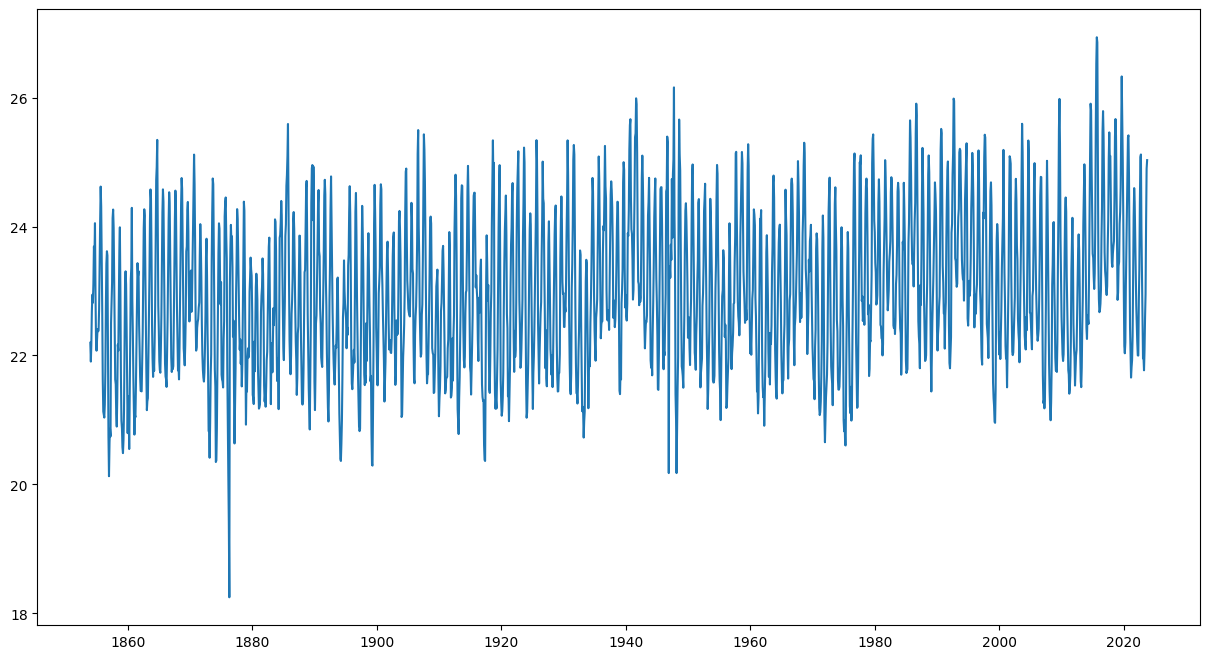

In [10]:
# para toda a séries p1_enso
index = p1_enso.index.tolist()
plt.figure(figsize=(15,8))
plt.plot(index, p1_enso['sst'])
plt.show()

#### Plotando para as primeiras leituras

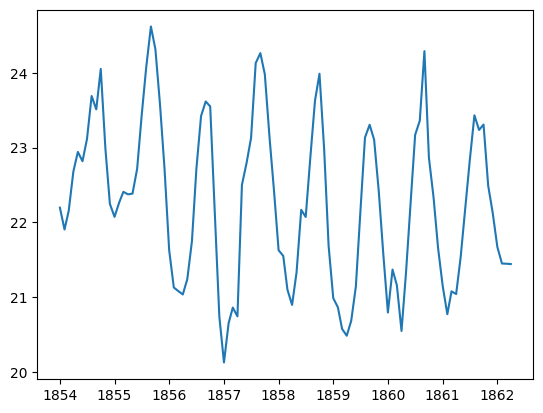

In [11]:
#plotando a temperatura do ponto atravéz do tempo para as primeiras 100 leituras
index = p1_enso.index.tolist()
plt.plot(index[:100],p1_enso['sst'][:100])
plt.show()

### Dividindo em treino e teste para os pontos do globo escolhidos, no caso o ENSO

In [12]:
DATE_TO_SPLIT = '2021-12-01' #data limite para dividir em treino[:DATA_LIMITE] e teste[DATA_LIMITE:]
END_WINDOW = HORIZONTE #janela para usar como teste no conjunto de teste 

# enso
treino_enso, teste_enso = SSTHelper.split_train_test(p1_enso, DATE_TO_SPLIT)
treino_enso.drop(['lat', 'lon'], axis=1, inplace=True)
teste_enso.drop(['lat', 'lon'], axis=1, inplace=True)

# IR PARA SEÇÃO ANEXO para realizar a previsão para os outros pontos definidos

In [13]:
print('Shape de treino (ENSO): ', treino_enso.shape)
print('Shape de teste (ENSO): ' , teste_enso.shape)

Shape de treino (ENSO):  (2016, 1)
Shape de teste (ENSO):  (22, 1)


#### Dados de treino (ENSO)

In [14]:
treino_enso.tail()

,sst
time,
2021-08-01,24.145559
2021-09-01,24.596079
2021-10-01,24.381094
2021-11-01,23.861654
2021-12-01,23.306463


#### Dados de teste (ENSO) - limitado ao horizonte

In [15]:
teste_enso.tail(HORIZONTE)

,sst
time,
2022-11-01,23.949959
2022-12-01,23.302540
2023-01-01,22.738529
2023-02-01,21.955500
2023-03-01,21.979300
2023-04-01,21.770193
2023-05-01,22.074417
2023-06-01,22.585289
2023-07-01,22.950830


### Otimizando os hiper-parâmetros do SARIMA para o conjunto de treino

Os hiperparâmetros `order`$= (p, q, d)$ e `sazonal_order`$=(P, Q, D, m)$ usados para treinar o modelos serão obtido pelo otimizador **auto_arima** do seguinte pacote, https://alkaline-ml.com/pmdarima/

O hiperparãmetro `order` é um parâmetro que tem a ver com a parte de trending do modelo:

 - $p$: Trend autoregression order

 - $q$: Moving average order

 - $d$: Trend moving average order

e os parâmetros de sazonalidade referente ao `sazonal_order`:

 - $P$: Seasonal autoregressive order

 - $D$: Seasonal difference order

 - $Q$: Seasonal moving average order

 - $m$: o número de passos no tempo para um único período de sazonalidade

#### Auto arima otimizator:


In [16]:
# https://alkaline-ml.com/pmdarima/
import pmdarima as pm

# Procura pelos melhores parâmetros (order e seasonal_order)
if (AUTO_TUNE):
    auto_model = pm.auto_arima(treino_enso, start_p=1, start_q=0,
                               max_p=5, max_q=0, m=24,
                               start_P=0, max_P=2,Q=0, 
                               seasonal=True,
                               d=1, D=1, trace=True,
                               error_action='ignore',  
                               suppress_warnings=True, 
                               stepwise=True)
    print(auto_model.aic())
    print(auto_model.summary())

### Treinando o modelo SARIMAX com o conjunto de treino do ponto no ENSO (El Niño-Southern Oscillation)

Ao obter os parâmetros `order` e `seadonal_order` do otimizador **auto_arima** do bloco anterior, treinamos o modelo com o conjunto de treino para um horizonte à frente.

In [17]:
# parâmetro obtidos do otimizador auto_arima
order_enso         = (5, 1, 0) #(p, q, d)
sazonal_order_enso = (2, 1, 0, 24) #(P, Q, D, m)

model_enso = SARIMAX(endog=treino_enso, order=order_enso, seasonal_order=sazonal_order_enso)
model_fit_enso = model_enso.fit()
y_predito_enso = model_fit_enso.forecast(steps = HORIZONTE)
#print(model_fit.summary())

### Resultado para o treino de um apenas um modelo

O conjunto de treino vai até 01/12/2021. Então, o modelo realiza a previsão para o horizonte definido

#### Valores preditos para o horizonte definido (12 meses)

In [18]:
y_predito_enso.to_frame()

,predicted_mean
2022-01-01,22.346516
2022-02-01,21.773057
2022-03-01,21.645948
2022-04-01,21.783298
2022-05-01,22.170572
2022-06-01,22.708853
2022-07-01,23.250181
2022-08-01,24.206224
2022-09-01,24.585447
2022-10-01,24.384045


#### Valores atuais para o horizonte definido (12 meses)

In [19]:
y_atual_enso = SSTHelper.get_subseries_by_date(teste_enso, DATE_TO_SPLIT, END_WINDOW)
y_atual_enso.tail(END_WINDOW)

,sst
time,
2022-01-01,22.776232
2022-02-01,22.454197
2022-03-01,22.204994
2022-04-01,22.001392
2022-05-01,21.998831
2022-06-01,22.841663
2022-07-01,23.332996
2022-08-01,24.358280
2022-09-01,25.077301


#### Erro quadrático médio obtido (RMSE)

In [24]:
SSTHelper.rmse(y_atual_enso, y_predito_enso)

0.45786544644015686

#### Mean Absolute Percentage Error (MAPE)

In [27]:
SSTHelper.mape(y_atual_enso, y_predito_enso)

0.01683551691542555

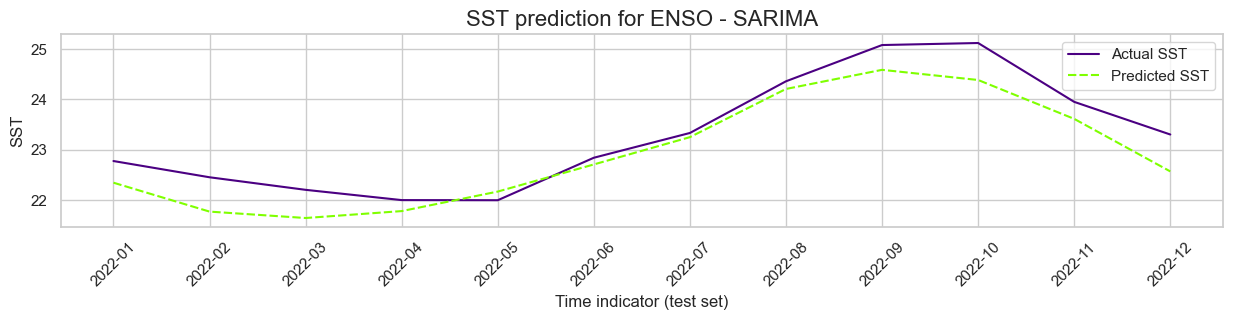

In [28]:
SSTHelper.default_plot(y_atual_enso['sst'], y_predito_enso, 'ENSO - SARIMA', 'SARIMA')

### SARIMA: Usando a técnica walk-forward validation (somente para o ENSO)

Será realizada uma [**walk-forward validation**](https://www.tutorialspoint.com/time_series/time_series_walk_forward_validation.htm) que é muito boa para usar em projetos próprios de forecasting de séries temporais.

Primeiro, o modelo é treinado com o dataset de treino. Então, é realizada a predição no próximo passo em que a predição é avaliada em contraste com o valor conhecido. O dataset de treino é expandido para incluir o novo valor conhecido e o processo é repetido. 

Na prática o modelo SARIMAX é re-treinado em cada iteração do loop assim que novos pontos do histórico ficam disponíveis.

Re-treinar o modelo a cada iteração torna a predição mais robusta, entretanto, aumenta o custo computacional de ter esses vários modelos.


##### Deslocando o conjunto de teste em HORIZONTE de meses à frente

Essa etapa é realizada para conseguirmos validar as previsões para os meses que não existem no conjunto de teste (ou seja, os meses que serão previstos pelo modelo)

In [29]:
teste_shifted_enso = teste_enso.copy() # faz uma cópia do conjunto de teste pois será deslocada no horizonte

for t in range(1, HORIZONTE):
    teste_shifted_enso['sst+'+str(t)] = teste_shifted_enso['sst'].shift(-t, freq='MS')
    
teste_shifted_enso = teste_shifted_enso.dropna(how='any')

#teste_shifted_enso.tail(HORIZONTE)

#### Criando os conjuntos de treino de acordo com a janela de treinamento

In [30]:
JANELA_TREINAMENTO = 96 # meses de janela de treino (8 anos) 

treino_ts_enso = treino_enso['sst'] #pegando somente a coluna com as temperaturas médias
teste_ts_enso = teste_shifted_enso

# criando um historico com apenas os valores da temperatura
historico_enso = [x for x in treino_ts_enso] # fazendo split dos valores sst para o conjunto de treino
historico_enso = historico_enso[(-JANELA_TREINAMENTO):] # do final do conjunto de treino até o tamanho da janela (fim -> até(96))

#print(treino_enso['sst'])
#print("histórico:", historico_enso[:10])
print("Conjunto de treino para a JANELA DE TREINAMENTO de: ", JANELA_TREINAMENTO, "meses")
treino_ts_enso.tail(JANELA_TREINAMENTO)

Conjunto de treino para a JANELA DE TREINAMENTO de:  96 meses


time
2014-01-01    22.424427
2014-02-01    22.256029
2014-03-01    22.622278
2014-04-01    22.568365
2014-05-01    22.488226
                ...    
2021-08-01    24.145559
2021-09-01    24.596079
2021-10-01    24.381094
2021-11-01    23.861654
2021-12-01    23.306463
Name: sst, Length: 96, dtype: float32

In [31]:
print("Conjunto de teste deslocado no HORIZONTE para os 12 meses:")
teste_ts_enso.tail(HORIZONTE)

Conjunto de teste deslocado no HORIZONTE para os 12 meses:


,sst,sst+1,sst+2,sst+3,sst+4,sst+5,sst+6,sst+7,sst+8,sst+9,sst+10,sst+11
time,,,,,,,,,,,,
2022-01-01,22.776232,22.454197,22.204994,22.001392,21.998831,22.841663,23.332996,24.358280,25.077301,25.117611,23.949959,23.302540
2022-02-01,22.454197,22.204994,22.001392,21.998831,22.841663,23.332996,24.358280,25.077301,25.117611,23.949959,23.302540,22.738529
2022-03-01,22.204994,22.001392,21.998831,22.841663,23.332996,24.358280,25.077301,25.117611,23.949959,23.302540,22.738529,21.955500
2022-04-01,22.001392,21.998831,22.841663,23.332996,24.358280,25.077301,25.117611,23.949959,23.302540,22.738529,21.955500,21.979300
2022-05-01,21.998831,22.841663,23.332996,24.358280,25.077301,25.117611,23.949959,23.302540,22.738529,21.955500,21.979300,21.770193
2022-06-01,22.841663,23.332996,24.358280,25.077301,25.117611,23.949959,23.302540,22.738529,21.955500,21.979300,21.770193,22.074417
2022-07-01,23.332996,24.358280,25.077301,25.117611,23.949959,23.302540,22.738529,21.955500,21.979300,21.770193,22.074417,22.585289
2022-08-01,24.358280,25.077301,25.117611,23.949959,23.302540,22.738529,21.955500,21.979300,21.770193,22.074417,22.585289,22.950830
2022-09-01,25.077301,25.117611,23.949959,23.302540,22.738529,21.955500,21.979300,21.770193,22.074417,22.585289,22.950830,24.066349


### Treino dos modelos para as janelas de treinamento com os parâmetros otimizados

In [32]:
%%time
predicoes_enso = list()
for t in range(teste_ts_enso.shape[0]):
    # treinando o modelo SARIMA para o historico definido
    model_enso = SARIMAX(endog=historico_enso, order=order_enso, seasonal_order=sazonal_order_enso) #https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html
    model_fit_enso = model_enso.fit()
    
    # realiza o forecast no HORIZONTE definido
    y_predito_enso = model_fit_enso.forecast(steps = HORIZONTE)
    
    # arredondando e adicionado à lista predições
    y_predito_enso = np.round(y_predito_enso, decimals = 1)
    predicoes_enso.append(y_predito_enso)
    
    # criando uma lista com os valores atuais
    y_atual_enso = list(teste_ts_enso.iloc[t]) # localiza o array do valor atual no índice t
    y_atual_enso = np.round(y_atual_enso, decimals = 1)
    
    # move the training window
    historico_enso.append(y_atual_enso[0])
    historico_enso.pop(0)
    
    print(t+1, '. Predicting time step: ', teste_ts_enso.index[t])
    print(t+1, ': predicted =', y_predito_enso)
    print(t+1, ': expected  =', y_atual_enso)
    print('----------')

1 . Predicting time step:  2022-01-01 00:00:00
1 : predicted = [22.6 22.  21.9 21.9 22.3 22.8 23.4 24.4 24.7 24.5 23.7 22.7]
1 : expected  = [22.8 22.5 22.2 22.  22.  22.8 23.3 24.4 25.1 25.1 23.9 23.3]
----------
2 . Predicting time step:  2022-02-01 00:00:00
2 : predicted = [22.3 22.1 22.2 22.5 23.  23.5 24.6 24.9 24.7 23.9 22.8 22.2]
2 : expected  = [22.5 22.2 22.  22.  22.8 23.3 24.4 25.1 25.1 23.9 23.3 22.7]
----------
3 . Predicting time step:  2022-03-01 00:00:00
3 : predicted = [22.4 22.4 22.6 23.1 23.6 24.7 25.1 24.8 24.  23.  22.3 22.2]
3 : expected  = [22.2 22.  22.  22.8 23.3 24.4 25.1 25.1 23.9 23.3 22.7 22. ]
----------
4 . Predicting time step:  2022-04-01 00:00:00
4 : predicted = [22.1 22.4 22.9 23.5 24.6 24.9 24.7 23.9 22.8 22.2 22.1 22.1]
4 : expected  = [22.  22.  22.8 23.3 24.4 25.1 25.1 23.9 23.3 22.7 22.  22. ]
----------
5 . Predicting time step:  2022-05-01 00:00:00
5 : predicted = [22.2 22.8 23.4 24.5 24.9 24.6 23.7 22.7 22.1 22.1 22.1 22.1]
5 : expected  = [22

#### Re-indexando as colunas para plotar o gráfico ao longo do tempo

In [33]:
eval_df = pd.DataFrame(predicoes_enso, columns=['sst+'+str(t) for t in range(1, HORIZONTE+1)])
eval_df['timestamp'] = teste_enso.index[0:len(teste_enso.index)-HORIZONTE+1]
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction_enso', var_name='h')
eval_df['atual'] = np.array(np.transpose(teste_ts_enso)).ravel()
eval_df.head(1250)

,timestamp,h,prediction_enso,atual
0,2022-01-01,sst+1,22.6,22.776232
1,2022-02-01,sst+1,22.3,22.454197
2,2022-03-01,sst+1,22.4,22.204994
3,2022-04-01,sst+1,22.1,22.001392
4,2022-05-01,sst+1,22.2,21.998831
...,...,...,...,...
127,2022-07-01,sst+12,23.0,22.585289
128,2022-08-01,sst+12,23.2,22.950830
129,2022-09-01,sst+12,24.2,24.066349
130,2022-10-01,sst+12,24.9,24.897844


#### Computando o MAPE: Mean Absolute Percentage Error sobre todas as predições e os valores atuais

O erro percentual absoluto médio ([MAPE](https://docs.oracle.com/cloud/help/pt_BR/pbcs_common/PFUSU/insights_metrics_MAPE.htm#PFUSU-GUID-C33B0F01-83E9-468B-B96C-413A12882334)) é uma medida de erro relativo que usa valores absolutos para impedir que os erros positivos e negativos cancelem uns aos outros e usa erros relativos para permitir que você compare a precisão da previsão entre métodos de série temporais.

$MAPE = \frac{1}{n} \sum_{t=1}^{n} |\frac{A_t - F_t}{A_t}|$ $->$ MAPE = Média de (abs((Atual - Forecast)/(Atual))

MAPE quanto menor o valor, melhor

In [34]:
SSTHelper.mape(eval_df['atual'], eval_df['prediction_enso'])

0.0139372031187597

### Plotando as predições Versus valor atual para o horizonte de meses (t, t+1,...,t+11) - para o ENSO

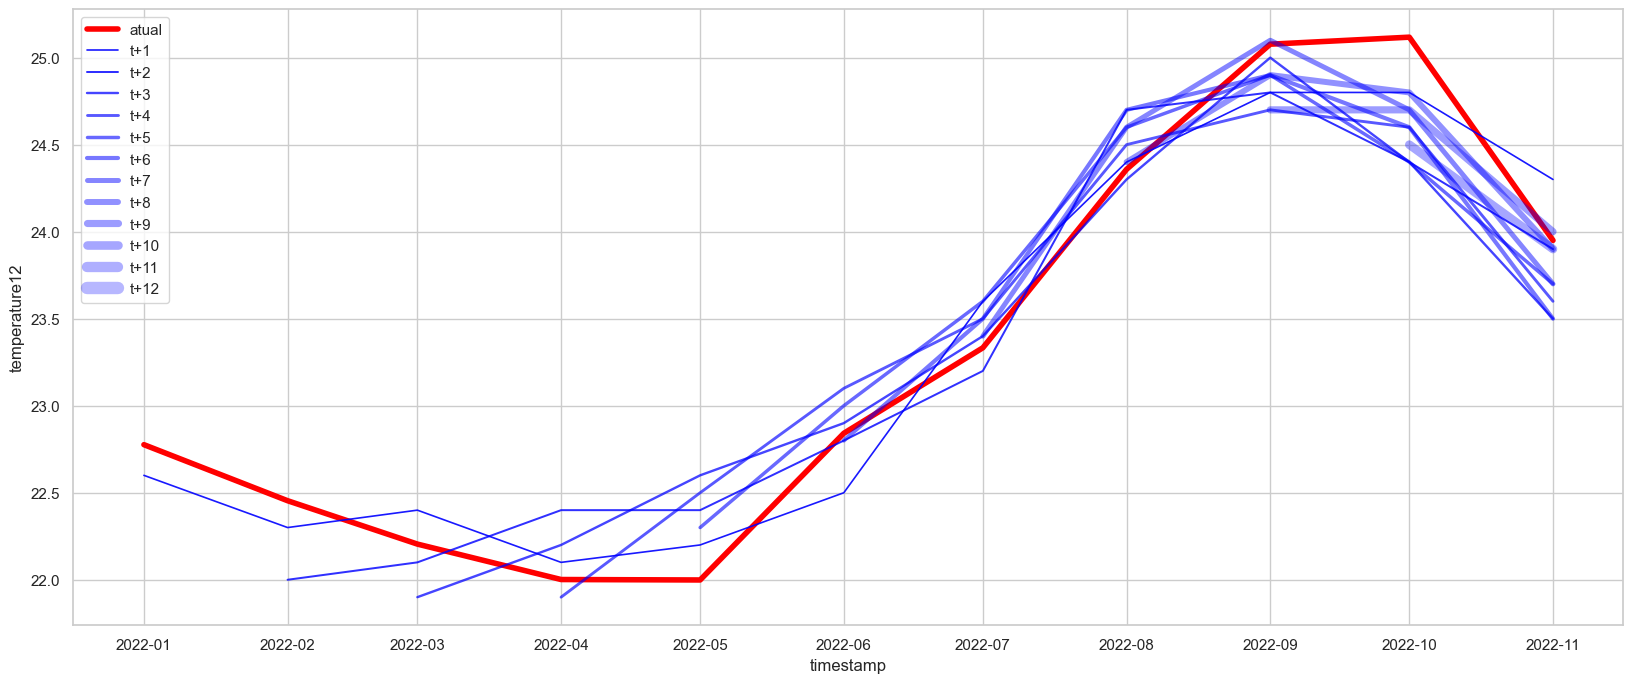

In [35]:
## Plotting multi step forecast
plot_df = eval_df[(eval_df.h=='sst+1')][['timestamp', 'atual']]
for t in range(1, HORIZONTE+1):
    plot_df['t+'+str(t)] = eval_df[(eval_df.h=='sst+'+str(t))]['prediction_enso'].values

plot_df.head()
fig = plt.figure(figsize=(20, 8))
plt.plot(plot_df['timestamp'], plot_df['atual'], color='red', linewidth=4.0, label='atual')

for t in range(1, HORIZONTE+1):
    x = plot_df['timestamp'][(t-1):]
    y = plot_df['t+'+str(t)][0:len(x)]
    plt.plot(x, y, color='blue', linewidth=1*math.pow(1.2,t), alpha=math.pow(0.9,t), label='t+'+str(t))

plt.legend()
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('temperature'+str(t), fontsize=12)
plt.show()

### Algumas informações sobre o modelo treinado para SST

In [36]:
print(model_fit_enso.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2757      0.139      1.989      0.047       0.004       0.547
ar.L2         -0.2107      0.190     -1.107      0.268      -0.584       0.162
ar.L3         -0.0382      0.172     -0.222      0.824      -0.376       0.299
ar.L4         -0.2664      0.112     -2.383      0.017      -0.486      -0.047
ar.L5         -0.0123      0.160     -0.077      0.939      -0.325       0.300
ar.S.L24      -0.8727      0.161     -5.436      0.000      -1.187      -0.558
ar.S.L48      -0.5091      0.128     -3.991      0.000      -0.759      -0.259
sigma2         0.0879      0.022      3.972      0.000       0.044       0.131


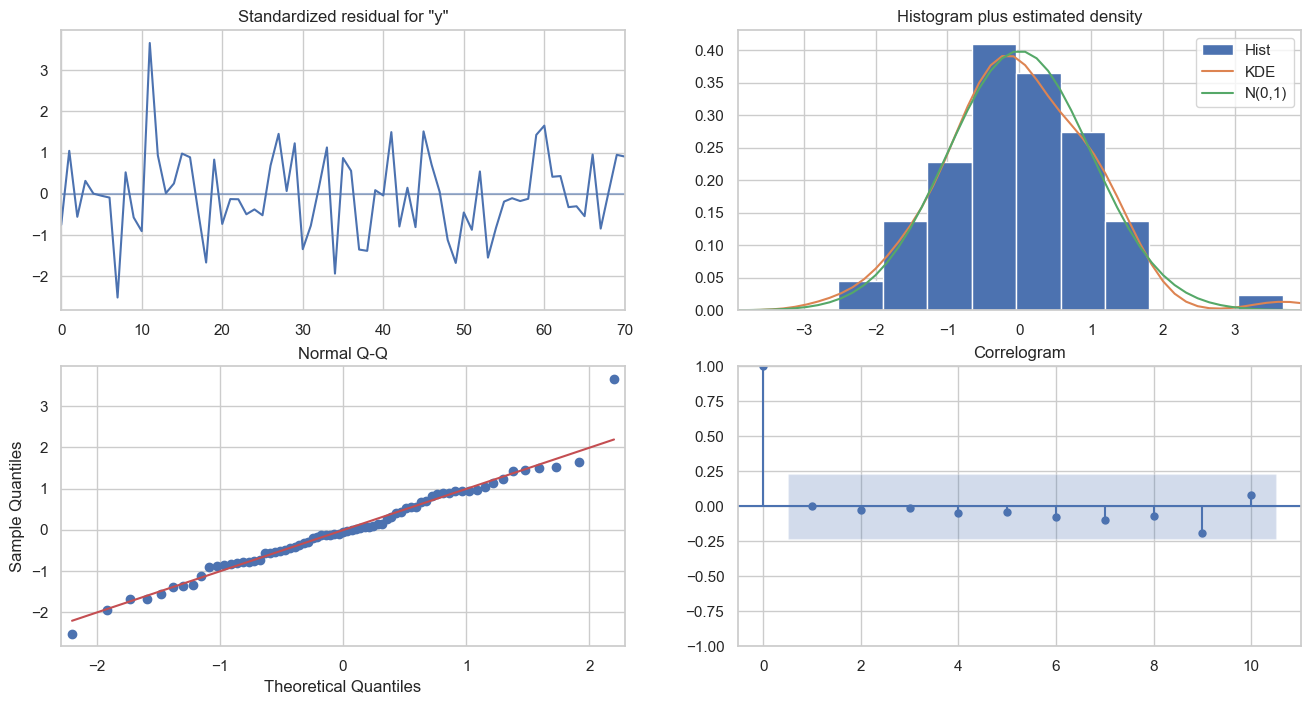

In [37]:
model_fit_enso.plot_diagnostics(figsize=(16, 8))
plt.show()

## Anexo:

#### Realizando a previsão para outros pontos do globo

In [38]:
%load_ext autoreload
%autoreload 2
from netuno import SSTHelper

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Dividindo em treino e teste para os outros pontos definidos (chile, mediterrâneo, atlântico, índico)

In [39]:
# chile
treino_chile, teste_chile = SSTHelper.split_train_test(p2_chile, DATE_TO_SPLIT)
treino_chile.drop(['lat', 'lon'], axis=1, inplace=True)
teste_chile.drop(['lat', 'lon'], axis=1, inplace=True)

# mediterrâneo
treino_medit, teste_medit = SSTHelper.split_train_test(p3_medit, DATE_TO_SPLIT)
treino_medit.drop(['lat', 'lon'], axis=1, inplace=True)
teste_medit.drop(['lat', 'lon'], axis=1, inplace=True)

# atlântico
treino_atlan, teste_atlan = SSTHelper.split_train_test(p4_atlan, DATE_TO_SPLIT)
treino_atlan.drop(['lat', 'lon'], axis=1, inplace=True)
teste_atlan.drop(['lat', 'lon'], axis=1, inplace=True)

# ìndico
treino_indic, teste_indic = SSTHelper.split_train_test(p5_indic, DATE_TO_SPLIT)
treino_indic.drop(['lat', 'lon'], axis=1, inplace=True)
teste_indic.drop(['lat', 'lon'], axis=1, inplace=True)

#### Treinando os modelos para todos os pontos restantes

In [40]:
# parâmetro obtidos do otimizador auto_arima
order_geral         = (5, 1, 0) #(p, q, d)
sazonal_order_geral = (2, 1, 0, 24) #(P, Q, D, m)

model_chile = SARIMAX(endog=treino_chile, order=order_geral, seasonal_order=sazonal_order_geral)
model_fit_chile = model_chile.fit()
y_predito_chile = model_fit_chile.forecast(steps = HORIZONTE)

model_medit = SARIMAX(endog=treino_medit, order=order_geral, seasonal_order=sazonal_order_geral)
model_fit_medit = model_medit.fit()
y_predito_medit = model_fit_medit.forecast(steps = HORIZONTE)

model_atlan = SARIMAX(endog=treino_atlan, order=order_geral, seasonal_order=sazonal_order_geral)
model_fit_atlan = model_atlan.fit()
y_predito_atlan = model_fit_atlan.forecast(steps = HORIZONTE)

model_indic = SARIMAX(endog=treino_indic, order=order_geral, seasonal_order=sazonal_order_geral)
model_fit_indic = model_indic.fit()
y_predito_indic = model_fit_indic.forecast(steps = HORIZONTE)

#### Pegando as subseries para os pontos

In [41]:
y_atual_chile = SSTHelper.get_subseries_by_date(teste_chile, DATE_TO_SPLIT, END_WINDOW)
y_atual_medit = SSTHelper.get_subseries_by_date(teste_medit, DATE_TO_SPLIT, END_WINDOW)
y_atual_atlan = SSTHelper.get_subseries_by_date(teste_atlan, DATE_TO_SPLIT, END_WINDOW)
y_atual_indic = SSTHelper.get_subseries_by_date(teste_indic, DATE_TO_SPLIT, END_WINDOW)

#### Calculando os erros RMSE e MAPE:

In [42]:
rmse_chile = SSTHelper.rmse(y_atual_chile, y_predito_chile)
mape_chile = SSTHelper.mape(y_atual_chile, y_predito_chile)

rmse_medit = SSTHelper.rmse(y_atual_medit , y_predito_medit)
mape_medit = SSTHelper.mape(y_atual_medit , y_predito_medit)

rmse_atlan = SSTHelper.rmse(y_atual_atlan, y_predito_atlan)
mape_atlan = SSTHelper.mape(y_atual_atlan, y_predito_atlan)

rmse_indic = SSTHelper.rmse(y_atual_indic, y_predito_indic)
mape_indic = SSTHelper.mape(y_atual_indic, y_predito_indic)

print("RMSE (Chile)", rmse_chile)
print("MAPE (Chile)", mape_chile)
print("----------------------\n")
print("RMSE (Mediterrâneo)", rmse_medit)
print("MAPE (Mediterrâneo)", mape_medit)
print("----------------------\n")
print("RMSE (Atlântico)", rmse_atlan)
print("MAPE (Atlântico)", mape_atlan)
print("----------------------\n")
print("RMSE (Índico)", rmse_indic)
print("MAPE (Índico)", mape_indic)
print("----------------------\n")

RMSE (Chile) 0.31612995922181814
MAPE (Chile) 0.013907741795411266
----------------------

RMSE (Mediterrâneo) 0.7618892609116027
MAPE (Mediterrâneo) 0.03000699753349101
----------------------

RMSE (Atlântico) 0.5083014279162089
MAPE (Atlântico) 0.017577316283200906
----------------------

RMSE (Índico) 0.20295235199686473
MAPE (Índico) 0.34931100095740125
----------------------



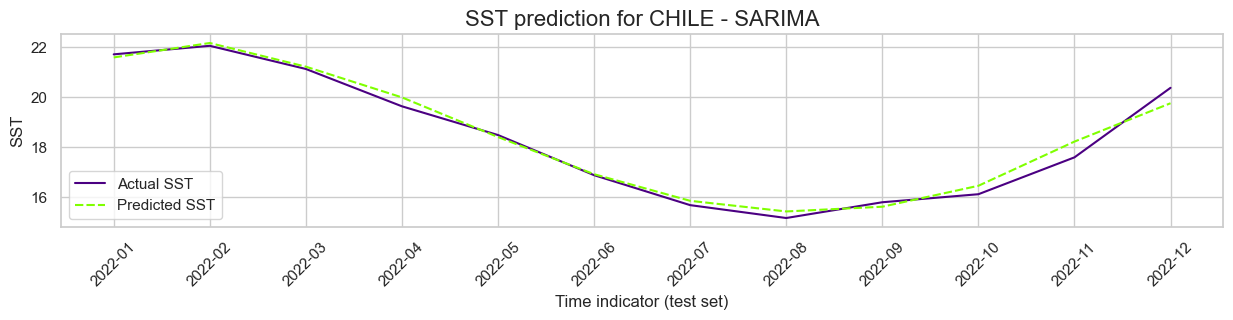

In [43]:
SSTHelper.default_plot(y_atual_chile['sst'], y_predito_chile, 'CHILE - SARIMA', 'SARIMA')

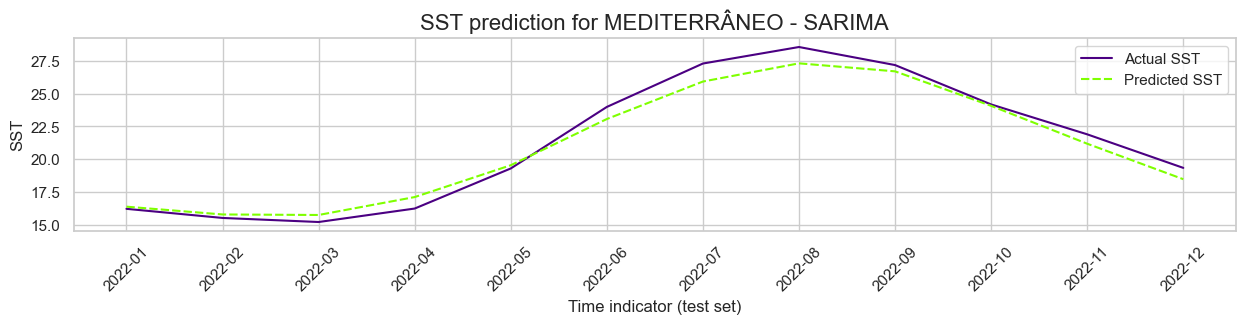

In [44]:
SSTHelper.default_plot(y_atual_medit['sst'], y_predito_medit, 'MEDITERRÂNEO - SARIMA', 'SARIMA')

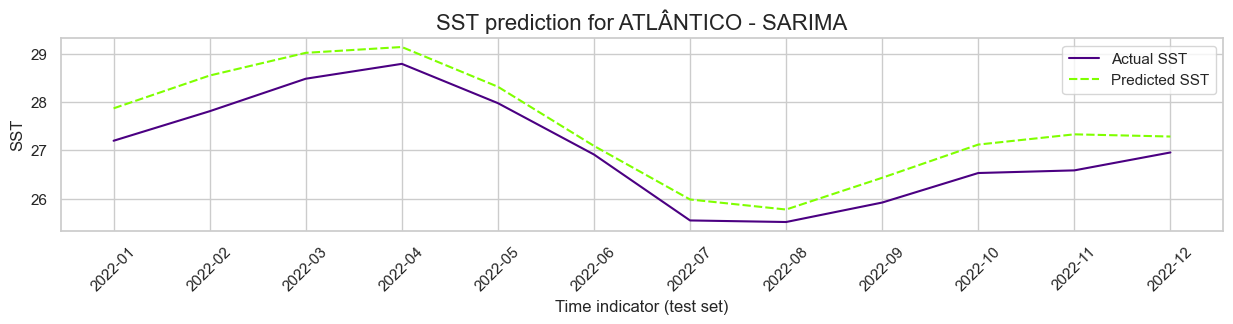

In [45]:
SSTHelper.default_plot(y_atual_atlan['sst'], y_predito_atlan, 'ATLÂNTICO - SARIMA', 'SARIMA')

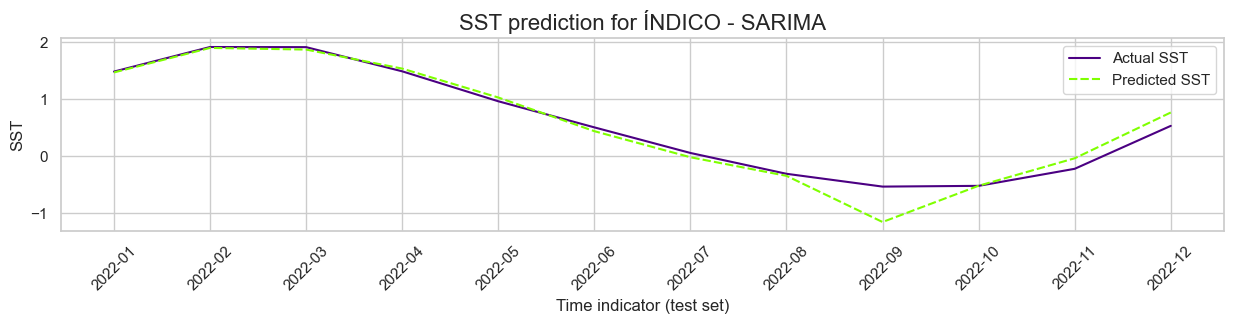

In [46]:
SSTHelper.default_plot(y_atual_indic['sst'], y_predito_indic, 'ÍNDICO - SARIMA', 'SARIMA')

#### Referências

Este projeto é uma adaptação das seguintes referências:

https://github.com/microsoft/ML-For-Beginners/blob/main/7-TimeSeries/2-ARIMA/README.md

https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

https://www.nbshare.io/notebook/136553745/Time-Series-Analysis-Using-ARIMA-From-StatsModels/

https://www.kaggle.com/code/ishanharshvardhan/time-series-analysis-and-forecasting-using-arima

